In [1]:
cd '/Users/jakesteinberg/Documents/CPT/vertical_structure/'

/Users/jakesteinberg/Documents/CPT/vertical_structure


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import pandas as pd
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from tqdm.notebook import tqdm
import seaborn 
import dedalus.public as de
import math 
from mode_decompositions import vertical_modes

import warnings 
warnings.filterwarnings('ignore')

In [3]:
cm26_ratio = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_Ratio_BTBC_KE.nc'
CMratio = xr.open_dataset(cm26_ratio)
cm26_ratio = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_Ratio_BTBC_KE_mean.nc'
CMratio_mean = xr.open_dataset(cm26_ratio)

In [4]:
cm26_bathy_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_depth.nc'
cmbathy = xr.open_dataset(cm26_bathy_path)
depth = cmbathy.depth

In [5]:
# way too many data points (breaks when I try to plot)
# smith_sand_path = '/Users/jakesteinberg/Documents/CPT/sandwell.nc'
# smith_sand = xr.open_dataset(smith_sand_path)
# data_coords = {'latitude': smith_sand.lat, 'longitude': smith_sand.lon}
# xda = xr.DataArray(data=smith_sand.topo, dims=['longitude','latitude'], coords=data_coords) 

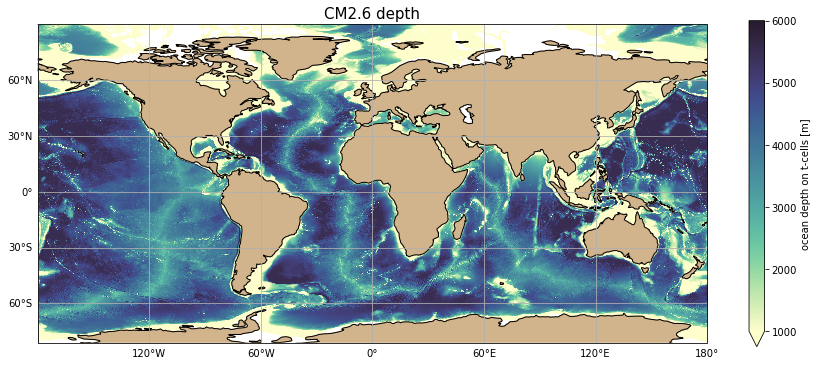

In [6]:
f, ax = plt.subplots(1,1,figsize=(15,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
depth.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.deep, add_colorbar=True, vmin=1000, vmax=6000) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('CM2.6 depth',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# ax.set_ylim([-65, 65]); ax.set_xlim([-80, 0]); 
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/depth.jpg', dpi=300)

In [6]:
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/CM26_global_slope.mat')
lon0 = x['lon'][:,0]
lat = x['lat'][:,0]
gamma0 = np.transpose(x['gamma']) # eastward 
alpha0 = np.transpose(x['alpha']) # northward 
roughness = np.transpose(x['rms_rough'])

In [7]:
roughness = np.concatenate((roughness[:,lon0 >= 0], roughness[:,lon0 < 0]),axis=1)
alpha0 = np.concatenate((alpha0[:,lon0 >= 0], alpha0[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((gamma0[:,lon0 >= 0], gamma0[:,lon0 < 0]),axis=1)

In [8]:
BT_BC = CMratio.Ratio_BTBC_KE.data
BT_BC_mean = CMratio_mean.Ratio_BTBC_KE.data
BT_BC_mean = np.concatenate((BT_BC_mean[:,lon0 >= 0], BT_BC_mean[:,lon0 < 0]),axis=1)

In [9]:
lon = np.concatenate((lon0[lon0 >= 0], lon0[lon0 < 0]+360))

In [10]:
data_coords = {'latitude': lat, 'longitude': lon}
xda = xr.DataArray(data=roughness, dims=['latitude','longitude'], coords=data_coords) 
slopeda = xr.DataArray(data=np.sqrt(gamma0**2 + alpha0**2), dims=['latitude','longitude'], coords=data_coords) 
BTBCm = xr.DataArray(data=BT_BC_mean, dims=['latitude','longitude'], coords=data_coords) 

In [11]:
rough_d = roughness[::4,::4].flatten()
depth_d = depth.data[::4,::4].flatten()
rough_d[depth_d < 1000] = np.nan

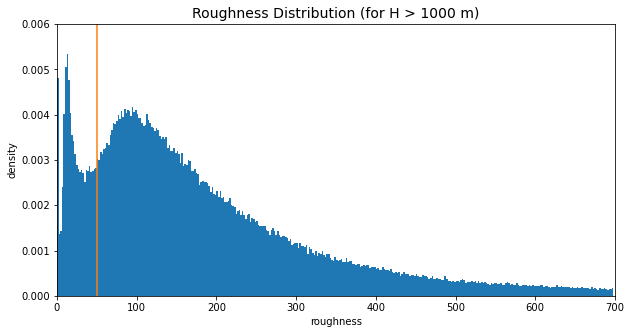

In [40]:
f, ax = plt.subplots(1,1,figsize=(10,5))
n, bins, patches = ax.hist(rough_d, bins=np.arange(0,700,2),density=True)
ax.plot([50,50],[0,0.0065])
ax.set_xlim([0,700]); ax.set_ylim([0,0.006])
ax.set_xlabel('roughness')
ax.set_ylabel('density')
ax.set_title('Roughness Distribution (for H > 1000 m)',fontsize=14)
plt.show()
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/rough_hist.jpg', dpi=300)

In [43]:
print(np.sum(~np.isnan(rough_d)))
len(np.where(rough_d <= 50)[0])/np.sum(~np.isnan(rough_d))

275137


0.1515281477954619

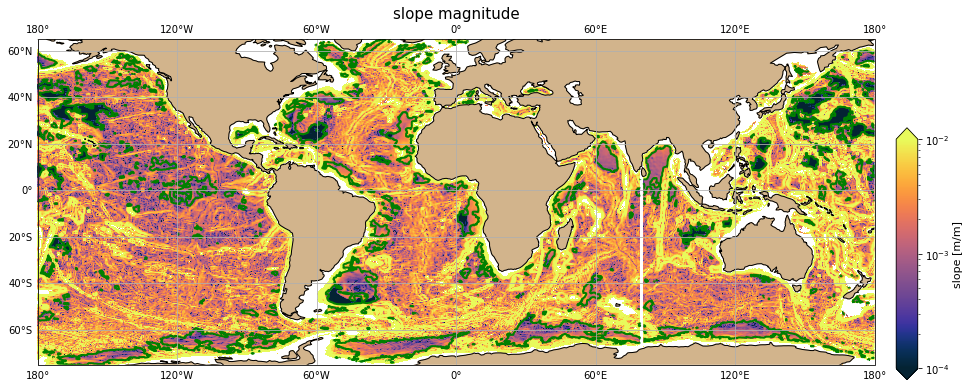

In [26]:
f, ax = plt.subplots(1,1,figsize=(15,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)}) # , subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
rr = slopeda.plot(ax=ax, cmap=cmo.cm.thermal, add_colorbar=False, norm=LogNorm(vmin=0.0001,vmax=0.01), \
         transform=ccrs.PlateCarree(central_longitude=0)) # vmin=10,vmax=1000
xda.plot.contour(ax=ax, levels=[50], colors='g', linewidths=2, transform=ccrs.PlateCarree()) 
ax.set_title('slope magnitude',fontsize=15)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
gl.ylabels_right = False
cbpos = [0.92, 0.15, 0.02, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(rr, cax=cax, orientation='vertical', label='roughness [m]', extend='both')
cb.set_label(label='slope [m/m]', color='k', fontsize=11)
ax.set_ylim([-75,65])
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/slope_w50.jpg', dpi=300)

(-75.0, 75.0)

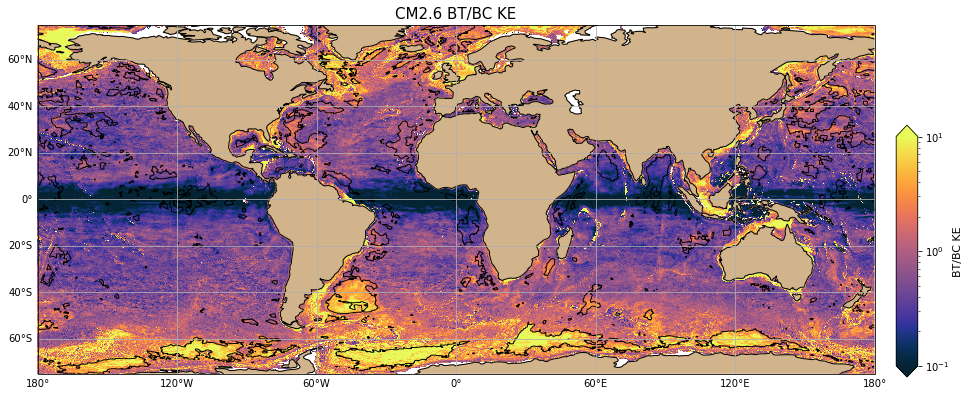

In [28]:
f, ax = plt.subplots(1,1,figsize=(15,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
btc = BTBCm.plot(ax=ax, cmap=cmo.cm.thermal, add_colorbar=False, norm=LogNorm(vmin=0.1, vmax=10),transform=ccrs.PlateCarree())
xda.plot.contour(ax=ax, levels=[50], colors='k', linewidths=0.95, transform=ccrs.PlateCarree()) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); 
gl = ax.gridlines(draw_labels=True)
ax.set_title('CM2.6 BT/BC KE',fontsize=15) # (w/ roughness < 50 m)
gl.xlabels_top = False; 
gl.ylabels_right = False

cbpos = [0.92, 0.15, 0.02, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(btc, cax=cax, orientation='vertical', label='BT/BC KE', extend='both')
cb.set_label(label='BT/BC KE', color='k', fontsize=11)
ax.set_ylim([-75,75])
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/ratio.jpg', dpi=250)

In [12]:
[Lon,Lat] = np.meshgrid(lon,lat)

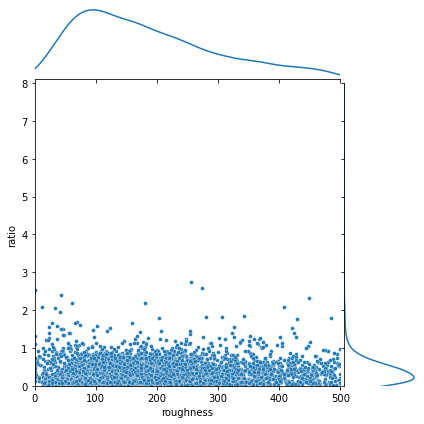

In [13]:
dec = 12
in1_0 = BTBCm.data[::dec,::dec].flatten()
in2_0 = xda.data[::dec,::dec].flatten()
in3_0 = Lat[::dec,::dec].flatten()
in3_0 = np.round(in3_0,-1)

in1_0[in1_0 > 8] = np.nan
in2_0[in2_0 > 500] = np.nan
in3_0[(in3_0 < -20) | (in3_0 > 0)] = np.nan

in1 = in1_0[~np.isnan(in3_0)]
in2 = in2_0[~np.isnan(in3_0)]
in3 = in3_0[~np.isnan(in3_0)]
data = {'ratio':in1, 'roughness':in2, 'lat': in3}
df = pd.DataFrame(data)

g = seaborn.JointGrid(data=df, x="roughness", y="ratio", \
                      xlim=(0, 500), ylim=(0, 8), palette='icefire', height=6, ratio=4, space=.05, )
g.plot_joint(seaborn.scatterplot, s=15)
g.plot_marginals(seaborn.kdeplot)
f = plt.gcf()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/ratio_rough_10S.jpg', dpi=250)

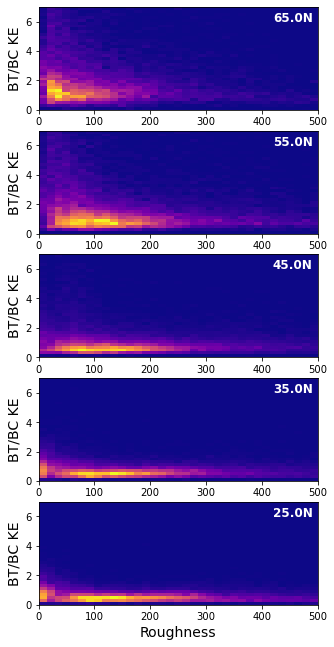

In [101]:
dec = 4 # decimate (sub-sample for plotting ease)
lat_bins = np.flipud([[-70,-60],[-60,-50],[-50,-40],[-40,-30],[-30,-20]])
lat_bins = np.flipud([[20,30],[30,40],[40,50],[50,60],[60,70]])
f,ax = plt.subplots(5,1,figsize=(5,11))
for i in range(5):
    in1_0 = BTBCm.data[::dec,::dec].flatten()
    in2_0 = xda.data[::dec,::dec].flatten()
    in3_0 = Lat[::dec,::dec].flatten()
    in1_0[in1_0 > 7] = np.nan
    in2_0[in2_0 > 500] = np.nan
    in3_0 = np.round(in3_0,-1)
    # nan out values outside of desired lat band
    in3_0[(in3_0 < lat_bins[i][0]) | (in3_0 > lat_bins[i][1])] = np.nan  
    in1 = in1_0[~np.isnan(in3_0)]
    in2 = in2_0[~np.isnan(in3_0)]
    in3 = in3_0[~np.isnan(in3_0)]
    re = np.where(~np.isnan(in1) & ~np.isnan(in2))[0]
    ax[i].hist2d(in2[re],in1[re],bins=[35,35],range=[[0, 500],[0,7]],\
              density=True,cmin=0,cmax=1,cmap=plt.get_cmap('plasma'));
    ax[i].set_ylabel('BT/BC KE',fontsize=14)
    ax[i].text(420,6,str(np.nanmean(lat_bins[i])) + 'N', color='w', fontsize=12, fontweight='bold')
ax[i].set_xlabel('Roughness',fontsize=14)
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/ratio_rough_2dhist_NH.jpg', dpi=250)

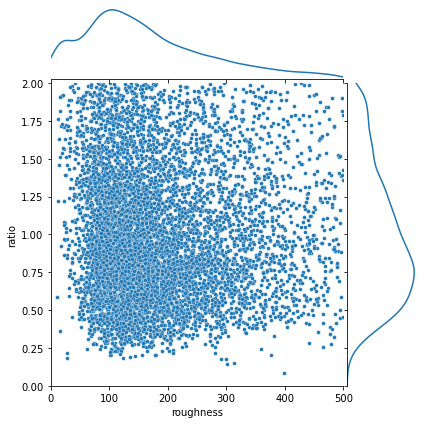

In [54]:
data = {'ratio':in1, 'roughness':in2, 'lat': in3}
df = pd.DataFrame(data)
g = seaborn.JointGrid(data=df, x="roughness", y="ratio", \
                      xlim=(0, 500), ylim=(0, 2), palette='icefire', height=6, ratio=4, space=.05, )
g.plot_joint(seaborn.scatterplot, s=15)
g.plot_marginals(seaborn.kdeplot)

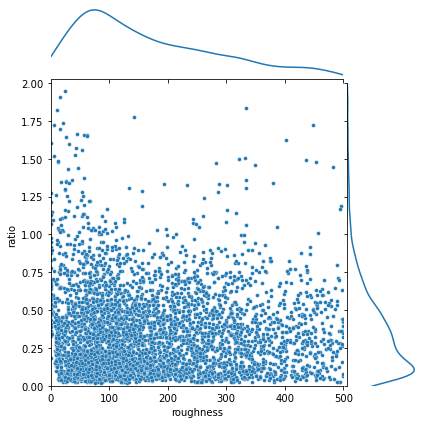

In [19]:
dec = 12
in1_0 = BTBCm.data[::dec,::dec].flatten()
in2_0 = xda.data[::dec,::dec].flatten()
in3_0 = Lat[::dec,::dec].flatten()
in3_0 = np.round(in3_0,-1)
in1_0[in1_0 > 2] = np.nan
in2_0[in2_0 > 500] = np.nan
in3_0[(in3_0 < 0) | (in3_0 > 20)] = np.nan
in1 = in1_0[~np.isnan(in3_0)]
in2 = in2_0[~np.isnan(in3_0)]
in3 = in3_0[~np.isnan(in3_0)]
data = {'ratio':in1, 'roughness':in2, 'lat': in3}
df = pd.DataFrame(data)
g = seaborn.JointGrid(data=df, x="roughness", y="ratio", \
                      xlim=(0, 500), ylim=(0, 2), palette='icefire', height=6, ratio=4, space=.05, )
g.plot_joint(seaborn.scatterplot, s=15)
g.plot_marginals(seaborn.kdeplot)

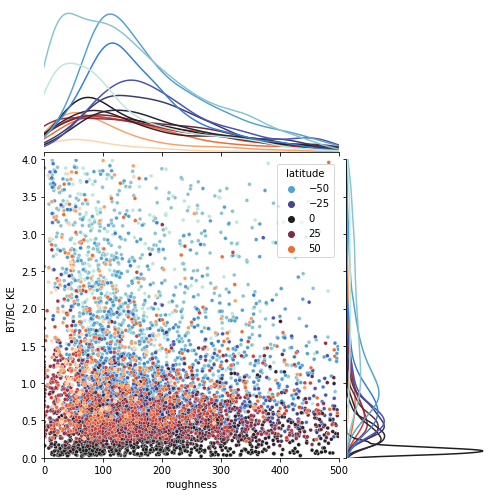

In [17]:
Lat2 = Lat[250:-450,:]
BTBC2 = BTBCm.data[250:-450,:]
rough2 = xda.data[250:-450,:]
dec = 24
in1_0 = BTBC2[::dec,::dec].flatten()
in2_0 = rough2[::dec,::dec].flatten()
in3_0 = Lat2[::dec,::dec].flatten()
in3_0 = np.round(in3_0,-1)
in1_0[in1_0 > 4] = np.nan
in2_0[in2_0 > 500] = np.nan
# in3_0[(in3_0 < -80) | (in3_0 > -60)] = np.nan
in1 = in1_0[~np.isnan(in2_0)]
in2 = in2_0[~np.isnan(in2_0)]
in3 = in3_0[~np.isnan(in2_0)]
data = {'BT/BC KE':in1, 'roughness':in2, 'latitude': in3}
df = pd.DataFrame(data)
g = seaborn.JointGrid(data=df, x="roughness", y="BT/BC KE", hue='latitude', \
                      xlim=(0, 500), ylim=(0, 4), palette='icefire', height=7, ratio=2, space=.05)
g.plot_joint(seaborn.scatterplot, s=15)
g.plot_marginals(seaborn.kdeplot)
f = plt.gcf()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/roughess_vs_ratio_lat.jpg', dpi=250)

In [14]:
cm26_eof_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_EOF_analysis.nc'
cmEOF = xr.open_dataset(cm26_eof_path)

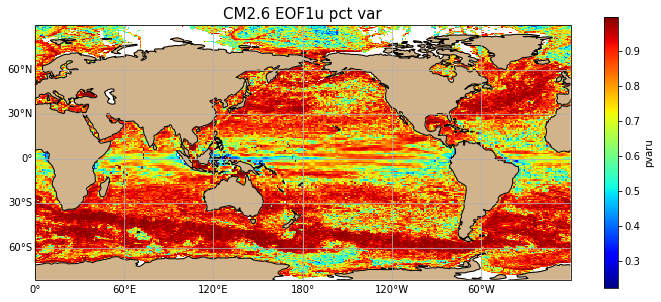

In [19]:
f, ax = plt.subplots(1,1,figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
cmEOF.pvaru.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), add_colorbar=True) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('CM2.6 EOF1u pct var',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False

In [16]:
pct_decay = np.nan*np.ones((len(cmEOF.lat),len(cmEOF.lon)))
for i in range(len(cmEOF.lon)):
    for j in range(len(cmEOF.lat)):
        if len(np.where(~np.isnan(cmEOF.EOF1u[:,j,i]))[0]) > 5:
            gi = np.where(~np.isnan(cmEOF.EOF1u[:,j,i]))[0]
            pct_decay[j,i] = np.nanmean(cmEOF.EOF1u[gi[-3:],j,i]) / np.nanmean(cmEOF.EOF1u[0:3,j,i])
    if (i/(len(cmEOF.lon)) >= 0.25) & (i/(len(cmEOF.lon)) < 0.26):
        print('25%')
    elif (i/(len(cmEOF.lon)) >= 0.5) & (i/(len(cmEOF.lon)) < 0.51): 
        print('50%')
    elif (i/(len(cmEOF.lon)) >= 0.75) & (i/(len(cmEOF.lon)) < 0.76): 
        print('75%')

25%
25%
25%
25%
50%
50%
50%
50%
75%
75%
75%
75%


In [44]:
# shift EOF longitudes to match with modes 
lon01 = cmEOF.lon.data
pct_decay1 = np.concatenate((pct_decay[:,lon01 >= 0], pct_decay[:,lon01 < 0]),axis=1)
eofu1 = np.concatenate((cmEOF.EOF1u[:,:,lon01 >= 0].data, cmEOF.EOF1u[:,:,lon01 < 0].data),axis=2)
eofv1 = np.concatenate((cmEOF.EOF1v[:,:,lon01 >= 0].data, cmEOF.EOF1u[:,:,lon01 < 0].data),axis=2)
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = cmEOF.lat.data

In [30]:
data_coords = {'latitude': lat1, 'longitude': lon1}
pct_decay_da = xr.DataArray(data=pct_decay1, dims=['latitude','longitude'], coords=data_coords) 
data_coords = {'depth': cmEOF.zl.data, 'latitude': lat1, 'longitude': lon1}
EOF1u = xr.DataArray(data=eofu1, dims=['depth','latitude','longitude'], coords=data_coords) 
EOF1v = xr.DataArray(data=eofu1, dims=['depth','latitude','longitude'], coords=data_coords) 

In [26]:
i1 = np.where((lon1 > 360-45) & (lon1 < 360-44.25))[0][0]
j1 = np.where((cmEOF.lat > -66) & (cmEOF.lat < -65.25))[0][0]
i2 = np.where((lon1 > 360-45) & (lon1 < 360-44.25))[0][0]
j2 = np.where((cmEOF.lat > -40) & (cmEOF.lat < -39.25))[0][0]
i3 = np.where((lon1 > 360-45) & (lon1 < 360-44.25))[0][0]
j3 = np.where((cmEOF.lat > 20) & (cmEOF.lat < 20.75))[0][0]
i4 = np.where((lon1 > 360-43) & (lon1 < 360-42.25))[0][0]
j4 = np.where((cmEOF.lat > 25) & (cmEOF.lat < 25.75))[0][0]

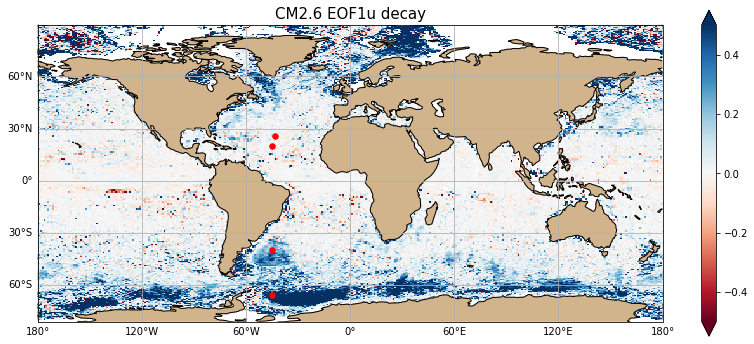

In [27]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
pct_decay_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'), add_colorbar=True, vmin=-.5,vmax=.5) 
ax.scatter(lon1[i1],cmEOF.lat[j1], s=30, color='r',transform=ccrs.PlateCarree())
ax.scatter(lon1[i2],cmEOF.lat[j2], s=30, color='r',transform=ccrs.PlateCarree())
ax.scatter(lon1[i3],cmEOF.lat[j3], s=30, color='r',transform=ccrs.PlateCarree())
ax.scatter(lon1[i4],cmEOF.lat[j4], s=30, color='r',transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('CM2.6 EOF1u decay',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/eof1u_decay.jpg', dpi=250)

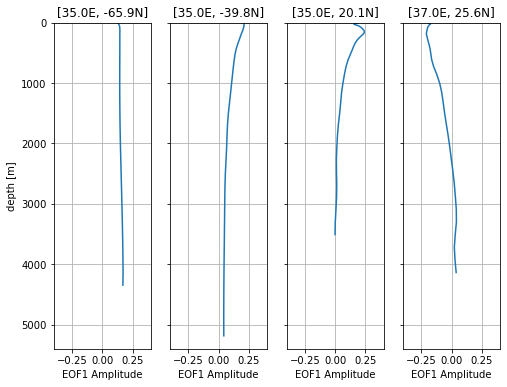

In [28]:
# plot EOFs at desired locations 
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(8,6),sharey=True)
ax1.plot(EOF1u[:,j1,i1].data,cmEOF.zl,linewidth=1.5)
ax1.set_title('['+str(np.round(cmEOF.lon[i1].data,1))+'E, '+str(np.round(cmEOF.lat[j1].data,1))+'N]')
ax1.set_xlim([-0.4,0.4])
ax1.set_xlabel('EOF1 Amplitude')
ax1.set_ylabel('depth [m]')
ax1.set_ylim([0,5400])
ax1.invert_yaxis()
ax1.grid()
ax2.plot(EOF1u[:,j2,i2].data,cmEOF.zl,linewidth=1.5)
ax2.set_title('['+str(np.round(cmEOF.lon[i2].data,1))+'E, '+str(np.round(cmEOF.lat[j2].data,1))+'N]')
ax2.set_xlim([-0.4,0.4])
ax2.set_xlabel('EOF1 Amplitude')
ax2.grid()
ax3.plot(EOF1u[:,j3,i3].data,cmEOF.zl,linewidth=1.5)
ax3.set_title('['+str(np.round(cmEOF.lon[i3].data,1))+'E, '+str(np.round(cmEOF.lat[j3].data,1))+'N]')
ax3.set_xlim([-0.4,0.4])
ax3.set_xlabel('EOF1 Amplitude')
ax3.grid()
ax4.plot(EOF1u[:,j4,i4].data,cmEOF.zl,linewidth=1.5)
ax4.set_title('['+str(np.round(cmEOF.lon[i4].data,1))+'E, '+str(np.round(cmEOF.lat[j4].data,1))+'N]')
ax4.set_xlim([-0.4,0.4])
ax4.set_xlabel('EOF1 Amplitude')
ax4.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_05_17/eof1u_decay_sites.jpg', dpi=250)

In [99]:
# subsample EOF grid (this is the grid on which I compute all modes ... goal to compare modes to EOFs on desired grid)
disc = 10
pct_decay_coarse = pct_decay_da[4:-25,:] # trim to -79:79 in lat
pct_decay_coarse = pct_decay_coarse[::disc,::disc]
EOF1u_coarse = EOF1u[:,4:-25,:]
EOF1u_coarse = EOF1u_coarse[:,::disc,::disc]
EOF1v_coarse = EOF1v[:,4:-25,:]
EOF1v_coarse = EOF1v_coarse[:,::disc,::disc]
lon_coarse = lon1[::disc]
lat_coarse = lat1[4:-25]
lat_coarse = lat_coarse[::disc]
print(np.shape(pct_decay_da)) # original shape 
print(np.shape(pct_decay_coarse)) # sub-sampled shape
print(np.shape(pct_decay_coarse)[0]*np.shape(pct_decay_coarse)[1]) # number of locations over which to calc. modes

(270, 360)
(25, 36)
900


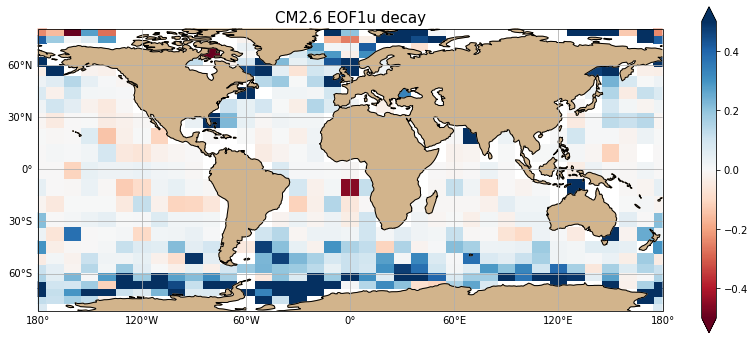

In [100]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
pct_decay_coarse.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'), add_colorbar=True, vmin=-.5,vmax=.5) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('CM2.6 EOF1u decay',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False

In [42]:
# load stratification (for now match N2 to CM2.6 grid)
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/global_1deg_N2smooth_slope.mat') # global_n2_2deg_slope.mat')
N2_lon = x['lon'][:,0]    
N2_lon[N2_lon < 0] = 360-np.abs(N2_lon[N2_lon < 0])
N2_lat = x['lat'][:,0]   
N2 = x['N2']      
N2 = np.concatenate((N2[N2_lon < 180,:,:], N2[N2_lon > 180,:,:]),axis=0)
N2_lon = np.concatenate((N2_lon[N2_lon < 180], N2_lon[N2_lon > 180]))
N2_z = -1.*x['dep'][:,0]

In [101]:
N2_match = np.nan*np.ones((len(pct_decay_coarse.longitude),len(pct_decay_coarse.latitude),len(N2_z)))
gamma_match = np.nan*np.ones((len(pct_decay_coarse.longitude),len(pct_decay_coarse.latitude)))
alpha_match = np.nan*np.ones((len(pct_decay_coarse.longitude),len(pct_decay_coarse.latitude)))
for i in range(len(pct_decay_coarse.latitude)):
    for j in range(len(pct_decay_coarse.longitude)):
        t_lon = pct_decay_coarse.longitude[j].data
        t_lat = pct_decay_coarse.latitude[i].data
        lon_in = np.where((N2_lon > (t_lon-1.5)) & (N2_lon < (t_lon+1.5)))[0][0]
        lat_in = np.where((N2_lat > (t_lat-1.5)) & (N2_lat < (t_lat+1.5)))[0][0]
        N2_match[j,i,:] = N2[lon_in,lat_in,:]
        lon_in = np.where((lon > (t_lon-1.5)) & (lon < (t_lon+1.5)))[0][0]
        lat_in = np.where((lat > (t_lat-1.5)) & (lat < (t_lat+1.5)))[0][0]
        gamma_match[j,i] = gamma0[lat_in,lon_in]
        alpha_match[j,i] = alpha0[lat_in,lon_in]
slope_match = np.sqrt(gamma_match**2 + alpha_match**2)

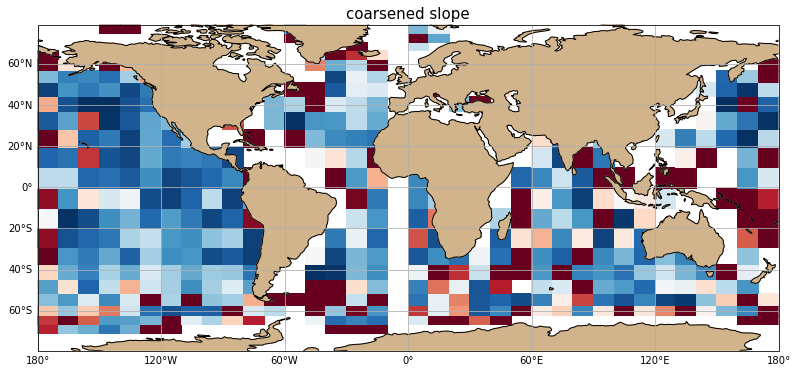

In [102]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lon_coarse,lat_coarse,np.transpose(slope_match),transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu_r'), vmin=0,vmax=0.01) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('coarsened slope',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False

In [224]:
def master_mode(nmodes,hkm, gamma_in,alpha_in,z_in,N2_in,lon_i,lat_i, z_out):
    z_0 = z_in
    master_K = 2.*np.pi/(hkm*1e3)  
    # prep outputs 
    modes_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, len(z_out), nmodes+1)) # [K,theta,z,mode_number]
    phase_speeds_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, nmodes+1)) 
    om_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, nmodes+1))
    fbmi = np.nan*np.ones((len(lat_i), len(lon_i)))
    thetas = np.nan*np.ones((len(lat_i), len(lon_i), nazimuths))
    lambda_squared_out = np.nan*np.ones((len(lat_i), len(lon_i), len(master_K), nazimuths, nmodes+1))
    fb_c_out = np.nan*np.ones((len(lat_i), len(lon_i), nmodes+1))
    fb1_out = np.nan*np.ones((len(lat_i), len(lon_i), len(z_out)))
    count = 0
    for masteri in range(len(lat_i)):
        for masterj in range(len(lon_i)):
            # -- smooth N2 by averaging across local lat/lon 
            locN2 = np.nanmean(np.nanmean(N2_in[lon_i[masterj]-3:lon_i[masterj]+4][:,lat_i[masteri]-3:lat_i[masteri]+4],axis=0),axis=0) 
            N_0 = np.sqrt(locN2) # [lon, lat, dep]
            # -- need only non-nan indices 
            g_i = np.where(~np.isnan(N_0))
            z_st = z_0[g_i]
            N_st = N_0[g_i]
            # -- if depth of ocean < 400 m or N2 are mostly nans, skip 
            if np.shape(g_i)[1] <= 35:
                continue 
            # if gamma/alpha is not defined 
            if ~np.isfinite(gamma_in[lon_i[masterj], lat_i[masteri]]):
                continue 
            # -- smoothing again
            N_st = savgol_filter(N_st,15,5)
            # print(N_st)

            # -- Domain (depends on z in cell above)
            h = np.round(np.nanmax(np.abs(z_st)),-1) - 10  # 3100
            z_basis = de.Chebyshev('z', Nz, interval=(-h, 0), dealias=3/2)
            domain = de.Domain([z_basis], np.complex128);
            ncc1 = domain.new_field(name='coef1'); # non-constant coefficient for variable N
            ncc2 = domain.new_field(name='coef2');
            zgrid = z_basis.grid(scale=1); # d = 1000.
            
            # print(z_st)
            # print(zgrid)
        
            f2 = interp1d(z_st.squeeze(), N_st.squeeze(), 'cubic'); # [inds]
            N = f2(np.expand_dims(zgrid,axis=1)).squeeze();
            zg = np.where((z_out >= np.min(zgrid)) & (z_out <= np.max(zgrid)))[0];
            
            # -- coriolis frequency -- 
            f0 = 2*(7.292*10**(-5))*np.sin(np.deg2rad(lat[lat_i[masteri]]))
            # -- beta
            beta = 2*(7.292*10**(-5))*np.cos(np.deg2rad(lat[lat_i[masteri]]))/(6357*1000)
            # -- zonal bottom slope (+ve means shallower east)
            gam = gamma_in[lon_i[masterj],lat_i[masteri]]
            # -- meridional bottom slope (+ve means shallower north)
            alpha = alpha_in[lon_i[masterj],lat_i[masteri]] 
            # -- slope 
            slope_theta = math.atan2(alpha, gam)
            slope_deg = np.array([np.rad2deg(slope_theta)])
            if slope_deg > 90:
                perp_deg = slope_deg - 90
            else:
                perp_deg = slope_deg + 90
            if slope_deg < 0:
                slope_deg = slope_deg + 180
                perp_deg = perp_deg + 180   
            perp_theta = np.deg2rad(perp_deg)
            slope_theta = np.deg2rad(slope_deg)
            master_deg = np.concatenate((azis[:,None],slope_deg[:,None],perp_deg[:,None])) # degrees to sweep through 
            master_deg = np.sort(master_deg, axis=0)
            master_theta = np.deg2rad(master_deg)
            
            # --- LOOP over all wavenumbers and angles 
            for mk in range(len(master_K)):           # loop over wavenumbers
                K = master_K[mk]
                for m in range(len(master_theta)):    # loop over thetas 
                    th = master_theta[m][0]           # angle from zonal line (was 0.)
                    k = K*np.cos(th)
                    l = K*np.sin(th)
                    K2 = k**2. + l**2.                  
                    ncc1 = domain.new_field(name='coef1'); # non-constant coefficient for variable N
                    ncc2 = domain.new_field(name='coef2');
                    ncc1['g'] = (f0**2.)/(N**2.)
                    ncc2['g'] = -((N**2.)/(beta*f0))*(gam*l/k - alpha)
                    # ----- Problem -----
                    problem = de.EVP(domain, variables=['phi', 'cphi_z'], eigenvalue='g2');
                    problem.parameters['coef1'] = ncc1;
                    problem.parameters['coef2'] = ncc2;
                    problem.parameters['K2'] = K2;
                    problem.add_equation("dz(cphi_z) + g2*phi  = 0");
                    problem.add_equation("cphi_z - coef1*dz(phi) = 0");
                    # -- bottom boundary condition choices -- 
                    # problem.add_bc("left(dz(phi)) = 0") # w = 0                 # w = 0 at z=-h BC (flat bottom)
                    # problem.add_bc("left(phi) = 0") # u = 0                     # u--> 0 at z=-h BC (de la lama 2016)
                    problem.add_bc("left(dz(phi) + coef2*(K2 + g2)*phi)= 0");      # sloping bottom BC 
                    # -- surface boundary condition (fixed)
                    problem.add_bc("right(dz(phi)) = 0");                          # surface BC
                    # ----- Solver ----- 
                    solver = problem.build_solver();
                    solver.solve_dense(solver.pencils[0]);
                    # -- Filter infinite/nan eigenmodes --
                    finite = np.isfinite(solver.eigenvalues);
                    solver.eigenvalues = solver.eigenvalues[finite];
                    solver.eigenvectors = solver.eigenvectors[:, finite];
                    # -- Sort eigenmodes by eigenvalue -- 
                    order = np.argsort(solver.eigenvalues);
                    solver.eigenvalues = solver.eigenvalues[order];
                    solver.eigenvectors = solver.eigenvectors[:, order];
                    
                    posi = np.argwhere(solver.eigenvalues > 0);
                    g2 = np.abs(np.real(solver.eigenvalues));
                    g = np.sqrt(g2) # this will place a NaN wherever g2<0!
                    phase_speeds_out[masteri, masterj, mk, m, :] = (1/g[0:nmodes+1])*f0
                    phase_speeds_out[masteri, masterj, mk, m, 0] = (1/np.sqrt(np.abs(g2[0])))*f0 # imaginary eigenvalue is the bottom trapped mode 
                    # ... but want a phase speed 
                    om = []
                    om.append(beta*K*np.cos(th)/(g2[0]+K2))
                    for om_i in range(nmodes):
                        om.append(beta*K*np.cos(th)/(g2[posi[om_i]]+K2))
                    z = solver.domain.grid(0);
                    # extract zeroth mode 
                    mode_number = 0
                    solver.set_state(mode_number);
                    phi = np.real(solver.state['phi']['g']);
                    cphiz = np.real(solver.state['cphi_z']['g']);
                    imax = np.argmax(np.abs(np.real(phi)))
                    norm = np.real(phi[imax])
                    mode_out0 = phi/norm
                    mode_out1 = np.interp(z_out[zg],zgrid,mode_out0)
                    modes_out[masteri, masterj, mk, m, zg, 0] = mode_out1
                    om_out[masteri, masterj, mk, m, :] = om
                    # extract modes 1 and higher 
                    for i in range(nmodes):
                        mode_number = int(posi[i]);
                        solver.set_state(mode_number);
                        phi = np.real(solver.state['phi']['g']);
                        cphiz = np.real(solver.state['cphi_z']['g']);
                        imax = np.argmax(np.abs(np.real(phi)));
                        norm = np.real(phi[imax]);
                        mode_out0 = phi/norm
                        mode_out1 = np.interp(z_out[zg],zgrid,mode_out0)
                        modes_out[masteri, masterj, mk, m, zg, i+1] = mode_out1
                    lambda_squared_out[masteri, masterj, mk, m, :] = g2[0:nmodes+1]
            fbmi[masteri,masterj] = np.int(np.where(master_theta == slope_theta)[0])
            thetas[masteri,masterj,:] = master_theta[:,0]
            # check against flat bottom modes 
            [G,Gz,c,epsilon,norm_const] = vertical_modes(np.flip(N)**2,np.flip(-1*zgrid),nmodes)
            fb_c_out[masteri,masterj,:] = c 
            fb1_out[masteri,masterj,zg] = np.interp(z_out[zg],zgrid,np.flip(Gz[:,1]))
            # print(str(count/(len(lon_i)*len(lat_i))))
            count = count + 1 
    
    return thetas, modes_out, om_out, lambda_squared_out, phase_speeds_out, fbmi, fb1_out, fb_c_out

In [225]:
hkm = np.array([100])                               # horizontal wavelengths to solve for
azis = np.arange(8,180,52)                          # azimuths to sweep over (big control on run time of code) (angles between 0 and 180 degrees)
nazimuths = len(azis) + 2                           # add two to include along/across slope
nmodes = 2                                          # does not include zeroth mode 
z_out = np.arange(-6000,0,100)                      # grid on which to place output 
Nz = 148                                            # number of grid points on which to define N (modes are very sensitive this this number)
lon_i = np.where((pct_decay_coarse.longitude > 310) & (pct_decay_coarse.longitude < 320))[0]        # longitude indices to sweep over
lat_i = np.where((pct_decay_coarse.latitude > 30) & (pct_decay_coarse.latitude < 40))[0]            # latitude indiced to sweep over 
N2_in = N2_match
gamma_in = gamma_match
alpha_in = alpha_match
z_in = N2_z

In [226]:
theta_o, modes_o, om_o, lambda_squared_o, phase_speeds_o, fbmi, fb1_o, fb_c_o = master_mode(nmodes,\
                                                                                            hkm, gamma_in, alpha_in, \
                                                                                            z_in, N2_in, lon_i, lat_i, z_out);

2022-05-18 10:45:08,404 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:08,845 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:09,119 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:09,382 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:09,567 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:09,839 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:10,104 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:10,533 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:10,808 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:11,050 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-05-18 10:45:11,392 proble

In [ ]:
# PROCEDURE 
# 1. consider pct decay of EOF1 (decide which modes are most appropriate)
# 2. using bathymetry, hydrography, and result in 1. solve for zeroth mode 
# (barotropic/1st baroclinic if flat bottom, 1st baroclinic if sloping bottom, ignore bottom trapped feature)
# 3. solve for modes (if sloping bottom solve for a few azimuths and pick mode with mininum rms difference)
# 4. take surface velocity and use selected mode to project on to interior velocity 
# 5. compare to bottom velocity 

In [ ]:
# barotropic 
# -- if pct_decay[i,j] > 0.5
# 1st baroclinic FB
# -- if pct_decay[i,j] < -0.1
# surface mode
# -- (if pct_decay[i,j] >=0) & (if pct_decay[i,j] < 0.5)